Tarea2.py 

El siguiente código muestra gráficos de la posición real y de la posición estimada del submarino. Se puede apreciar como la estimada tiende a la real a medida que se avanza en los gráficos.

Las iteraciones graficadas serán 0, 20, 30 y 47. Así es posible apreciar una evolución en la estimación, donde 0 es el inicio y 47 el final.

## b) y c) Gráficas para aprecias impacto de los sensores

### CASO 1 - Usando los 3 tipos de sensores: IMU, compás y encoders

In [ ]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()
            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            i+=1
if __name__ == "__main__":
    main()


### CASO 2 - Sólo con IMU (Inertial Measurement Unit)

In [ ]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
           # state_estimator.update([2], compass_data, r_compass)
           # state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)

            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()

            #print("contador: ", i)
            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            i +=1

if __name__ == "__main__":
    main()


### CASO 3 - Sólo con compás

In [ ]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
           # state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
           # state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)

            #if (i == 0) or (i == 10) or (i == 20) or (i == 30) or (i == 40) or (i == 47):
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()

            
            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            i +=1

if __name__ == "__main__":
    main()

### CASO 4 - Sólo con encoders

In [ ]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
           # state_estimator.update([4, 5], imu_data, r_imu)
           # state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)

            #if (i == 0) or (i == 10) or (i == 20) or (i == 30) or (i == 40) or (i == 47):
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()

            
            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            i +=1

if __name__ == "__main__":
    main()

### CASO 5 - Con IMU y Compás

In [ ]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            #state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)

            #if (i == 0) or (i == 10) or (i == 20) or (i == 30) or (i == 40) or (i == 47):
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()

           

            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            
            i +=1

            


if __name__ == "__main__":
    main()

### CASO 6 - Con IMU y encoders

In [ ]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            #state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)

            #if (i == 0) or (i == 10) or (i == 20) or (i == 30) or (i == 40) or (i == 47):
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()

           

            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            
            i +=1

            


if __name__ == "__main__":
    main()

### CASO 7 - Con compás y encoders

In [ ]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            #state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)

            #if (i == 0) or (i == 10) or (i == 20) or (i == 30) or (i == 40) or (i == 47):
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()

           

            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            
            i +=1

            


if __name__ == "__main__":
    main()

## d) Impacto al aumentar covarianza del ruido

### Caso 1 Original sin modificaciones de ruido

In [ ]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    # matriz de covarianza de ruido del modelo (?)
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # Matriz de covarianza de ruido
    # create measurement noise covariance matrices
    # cada sensor tiene su matriz de covarianza de ruido (?)
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()
            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            i+=1
if __name__ == "__main__":
    main()

### Ahora con modificaciones de ruido

### caso 2 Sólo IMU modificado

In [ ]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    #r_imu[0][0] = 0.01
    #r_imu[1][1] = 0.03

    #IMU MODIFICADO
    r_imu[0][0] = 0.3
    r_imu[1][1] = 0.5

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            #state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)

            #if (i == 0) or (i == 10) or (i == 20) or (i == 30) or (i == 40) or (i == 47):
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()

           

            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            
            i +=1

            


if __name__ == "__main__":
    main()

### caso 3 Sólo compás modificado

In [ ]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # create measurement noise covariance matrices
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    #r_compass[0][0] = 0.02

    #Compás modificado
    r_compass[0][0] = 0.4


    r_encoder = np.zeros([1, 1])
    r_encoder[0][0] = 0.001

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()
            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            i+=1
if __name__ == "__main__":
    main()

### caso 4 Sólo encoders modificado

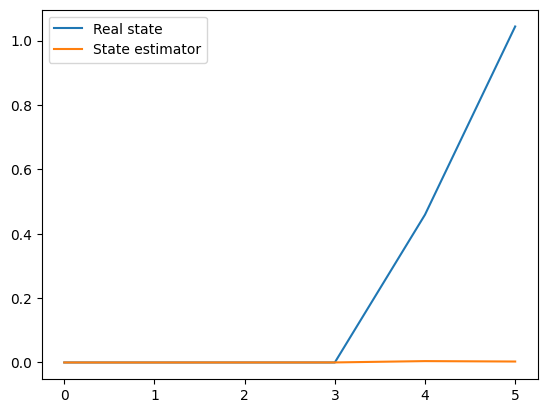

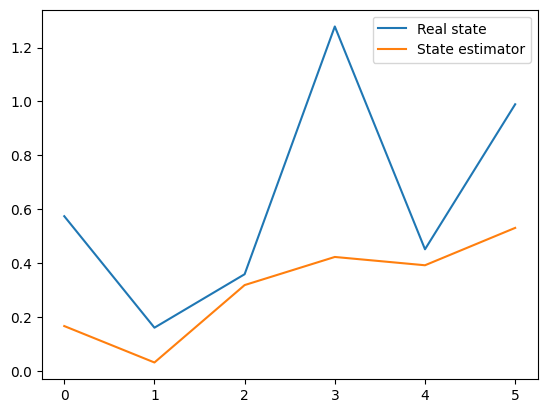

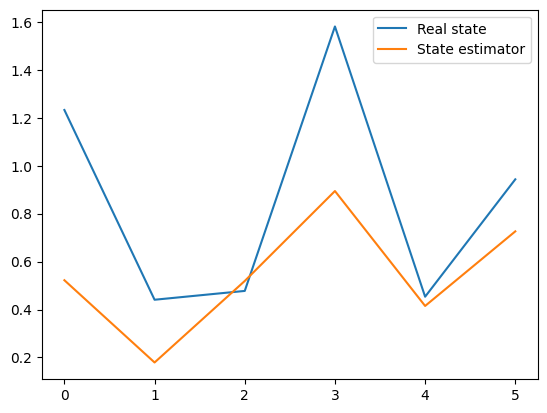

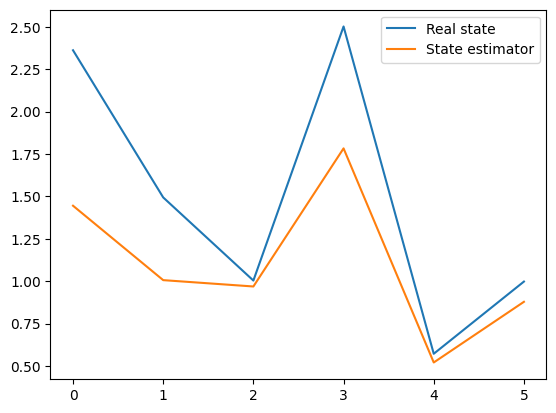

Difference:  [0.917 0.488 0.035 0.719 0.051 0.119]


In [26]:
#!/usr/bin/env python

from ukf import UKF
import csv
import numpy as np
import math


def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed'''
    ret = np.zeros(len(x_in))
    ret[0] = x_in[0] + timestep * x_in[3] * math.cos(x_in[2])
    ret[1] = x_in[1] + timestep * x_in[3] * math.sin(x_in[2])
    ret[2] = x_in[2] + timestep * x_in[4]
    ret[3] = x_in[3] + timestep * x_in[5]
    ret[4] = x_in[4]
    ret[5] = x_in[5]
    return ret


def main():
    np.set_printoptions(precision=3)

    # Process Noise
    # matriz de covarianza de ruido del modelo (?)
    q = np.eye(6)
    q[0][0] = 0.0001
    q[1][1] = 0.0001
    q[2][2] = 0.0004
    q[3][3] = 0.0025
    q[4][4] = 0.0025
    q[5][5] = 0.0025

    # Matriz de covarianza de ruido
    # create measurement noise covariance matrices
    # cada sensor tiene su matriz de covarianza de ruido (?)
    r_imu = np.zeros([2, 2])
    r_imu[0][0] = 0.01
    r_imu[1][1] = 0.03

    r_compass = np.zeros([1, 1])
    r_compass[0][0] = 0.02

    r_encoder = np.zeros([1, 1])
    #r_encoder[0][0] = 0.001
    # Encoders modificados
    r_encoder[0][0] = 0.5

    # pass all the parameters into the UKF!
    # number of state variables, process noise, initial state, initial coariance, three tuning paramters, and the iterate function
    state_estimator = UKF(6, q, np.zeros(6), 0.0001*np.eye(6), 0.04, 0.0, 2.0, iterate_x)

    with open('datos.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        last_time = 0
        # read data
        i=0
        for row in reader:
            row = [float(x) for x in row]

            cur_time = row[0]
            d_time = cur_time - last_time
            real_state = np.array([row[i] for i in [5, 6, 4, 3, 2, 1]])

            # create an array for the data from each sensor
            compass_hdg = row[9]
            compass_data = np.array([compass_hdg])

            encoder_vel = row[10]
            encoder_data = np.array([encoder_vel])

            imu_accel = row[7]
            imu_yaw_rate = row[8]
            imu_data = np.array([imu_yaw_rate, imu_accel])

            last_time = cur_time

            # prediction is pretty simple
            state_estimator.predict(d_time)

            # updating isn't bad either
            # remember that the updated states should be zero-indexed
            # the states should also be in the order of the noise and data matrices
            state_estimator.update([4, 5], imu_data, r_imu)
            state_estimator.update([2], compass_data, r_compass)
            state_estimator.update([3], encoder_vel, r_encoder)

            #print("--------------------------------------------------------")
            #print("Real state: ", real_state)
            #print("Estimated state: ", state_estimator.get_state())
            #print("Difference: ", real_state - state_estimator.get_state())

            import matplotlib.pyplot as plt

            x = [0,1,2,3,4,5]

            #print("eje x: ", x)
            if (i == 0) or (i == 20) or (i == 30) or (i == 47):

                f = plt.figure()

                plt.plot(x, real_state, label ='Real state') 
                plt.plot(x, state_estimator.get_state(), label ='State estimator') 

                # Function add a legend  
                plt.legend()

                plt.show()
            if (i == 47):
                print("Difference: ", real_state - state_estimator.get_state())
            i+=1
if __name__ == "__main__":
    main()